In [1]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

BASE_URL = "https://api.coingecko.com/api/v3/coins/solana/market_chart"
VS_CURRENCY = "usd"

TOTAL_HOURS = 5000
HOURS_PER_DAY = 24
TOTAL_DAYS = TOTAL_HOURS / HOURS_PER_DAY  # ≈208 días
BLOCK_DAYS = 90  # CoinGecko limita a 90 días por request
SLEEP_SECONDS = 5  # pausa entre requests para no superar rate limit

all_prices = []
all_volumes = []

days_remaining = TOTAL_DAYS
while days_remaining > 0:
    days_to_fetch = min(BLOCK_DAYS, days_remaining)
    print(f"🚀 Descargando bloque de {days_to_fetch:.1f} días...")

    params = {
        "vs_currency": VS_CURRENCY,
        "days": days_to_fetch
    }

    try:
        response = requests.get(BASE_URL, params=params)
        if response.status_code != 200:
            print(f"❌ Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        all_prices.extend(data['prices'])
        all_volumes.extend(data['total_volumes'])

    except Exception as e:
        print(f"❌ Error en request: {e}")
        break

    days_remaining -= days_to_fetch
    time.sleep(SLEEP_SECONDS)

# Crear DataFrame
df = pd.DataFrame(all_prices, columns=['timestamp','price'])
df['volume'] = [v[1] for v in all_volumes]
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Resample a 1h
df_ohlc = df.resample('1h', on='timestamp').agg({
    'price': ['first','max','min','last'],
    'volume': 'sum'
})
df_ohlc.columns = ['open','high','low','close','volume']
df_ohlc.reset_index(inplace=True)

# Guardar CSV
df_ohlc.to_csv("solana_5000h_coingecko.csv", index=False)
print(f"✅ Dataset guardado con {len(df_ohlc)} filas (≈{len(df_ohlc)} horas)")


🚀 Descargando bloque de 90.0 días...
🚀 Descargando bloque de 90.0 días...
🚀 Descargando bloque de 28.3 días...
✅ Dataset guardado con 2160 filas (≈2160 horas)


In [3]:
import pandas as pd

# 1️⃣ Cargar CSV
df = pd.read_csv("solana_5000h_coingecko.csv")

# 2️⃣ Verificar valores faltantes
print(df.isna().sum())

# 3️⃣ Convertir timestamp a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 4️⃣ Ordenar cronológicamente
df = df.sort_values('timestamp')

# 5️⃣ Eliminar duplicados
df = df.drop_duplicates(subset='timestamp')

# 6️⃣ Asegurarse que columnas numéricas sean float
numeric_cols = ['open','high','low','close','volume']
df[numeric_cols] = df[numeric_cols].astype(float)

# 7️⃣ Revisar tipos de datos finales
print(df.dtypes)

# 8️⃣ Vista rápida de los datos
print(df.head())


timestamp    0
open         1
high         1
low          1
close        1
volume       0
dtype: int64
timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume              float64
dtype: object
            timestamp        open        high         low       close  \
0 2025-06-10 06:00:00  158.123005  158.123005  158.123005  158.123005   
1 2025-06-10 07:00:00  158.317370  158.317370  158.317370  158.317370   
2 2025-06-10 08:00:00  158.431356  158.431356  158.431356  158.431356   
3 2025-06-10 09:00:00  158.140291  158.140291  158.140291  158.140291   
4 2025-06-10 10:00:00  158.833437  158.833437  158.833437  158.833437   

         volume  
0  8.566360e+09  
1  8.602750e+09  
2  8.697987e+09  
3  8.718309e+09  
4  8.458221e+09  


In [4]:
import pandas as pd
import numpy as np

print("🚀 Iniciando preparación y feature engineering del dataset de SOL...")

# 1️⃣ Cargar CSV
print("📥 Cargando dataset desde solana_5000h_coingecko.csv")
df = pd.read_csv("solana_5000h_coingecko.csv")

# 2️⃣ Verificar valores faltantes
print("🔍 Verificando valores faltantes por columna:")
print(df.isna().sum())

# 3️⃣ Convertir timestamp a datetime
print("🕒 Convertiendo columna 'timestamp' a formato datetime")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 4️⃣ Ordenar cronológicamente
print("📊 Ordenando dataset por fecha")
df = df.sort_values('timestamp')

# 5️⃣ Eliminar duplicados
print("🗑 Eliminando duplicados si los hay")
df = df.drop_duplicates(subset='timestamp')

# 6️⃣ Asegurar que columnas numéricas sean float
numeric_cols = ['open','high','low','close','volume']
df[numeric_cols] = df[numeric_cols].astype(float)

# 7️⃣ Crear features derivados
print("⚙️ Generando features derivados...")

# Retornos y log-retornos
df['returns'] = df['close'].pct_change()
df['log_returns'] = np.log(df['close']/df['close'].shift(1))

# Velocidad de cambio y rango de la vela
df['change'] = df['close'] - df['open']
df['range'] = df['high'] - df['low']

# Medias móviles simples y exponenciales
df['SMA_3'] = df['close'].rolling(window=3).mean()
df['SMA_6'] = df['close'].rolling(window=6).mean()
df['EMA_6'] = df['close'].ewm(span=6, adjust=False).mean()

# Volumen relativo
df['vol_ma3'] = df['volume'].rolling(3).mean()
df['vol_ratio'] = df['volume'] / df['vol_ma3']

# 8️⃣ Crear target para predicción
# Clasificación: 1 si sube la siguiente hora, 0 si baja
df['target_up'] = (df['close'].shift(-1) > df['close']).astype(int)
# Regresión: precio de cierre de la siguiente hora
df['target_price'] = df['close'].shift(-1)

# 9️⃣ Guardar dataset preparado
output_file = "solana_5000h_preparado.csv"
df.to_csv(output_file, index=False)
print(f"✅ Dataset preparado y guardado en {output_file}")

# Vista rápida de los datos procesados
print("👀 Primeras filas del dataset preparado:")
print(df.head())


🚀 Iniciando preparación y feature engineering del dataset de SOL...
📥 Cargando dataset desde solana_5000h_coingecko.csv
🔍 Verificando valores faltantes por columna:
timestamp    0
open         1
high         1
low          1
close        1
volume       0
dtype: int64
🕒 Convertiendo columna 'timestamp' a formato datetime
📊 Ordenando dataset por fecha
🗑 Eliminando duplicados si los hay
⚙️ Generando features derivados...
✅ Dataset preparado y guardado en solana_5000h_preparado.csv
👀 Primeras filas del dataset preparado:
            timestamp        open        high         low       close  \
0 2025-06-10 06:00:00  158.123005  158.123005  158.123005  158.123005   
1 2025-06-10 07:00:00  158.317370  158.317370  158.317370  158.317370   
2 2025-06-10 08:00:00  158.431356  158.431356  158.431356  158.431356   
3 2025-06-10 09:00:00  158.140291  158.140291  158.140291  158.140291   
4 2025-06-10 10:00:00  158.833437  158.833437  158.833437  158.833437   

         volume   returns  log_returns

/tmp/ipykernel_16143/3536121846.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['returns'] = df['close'].pct_change()


🚀 Iniciando EDA automático para SOL...
📊 Visualizando precio de cierre...


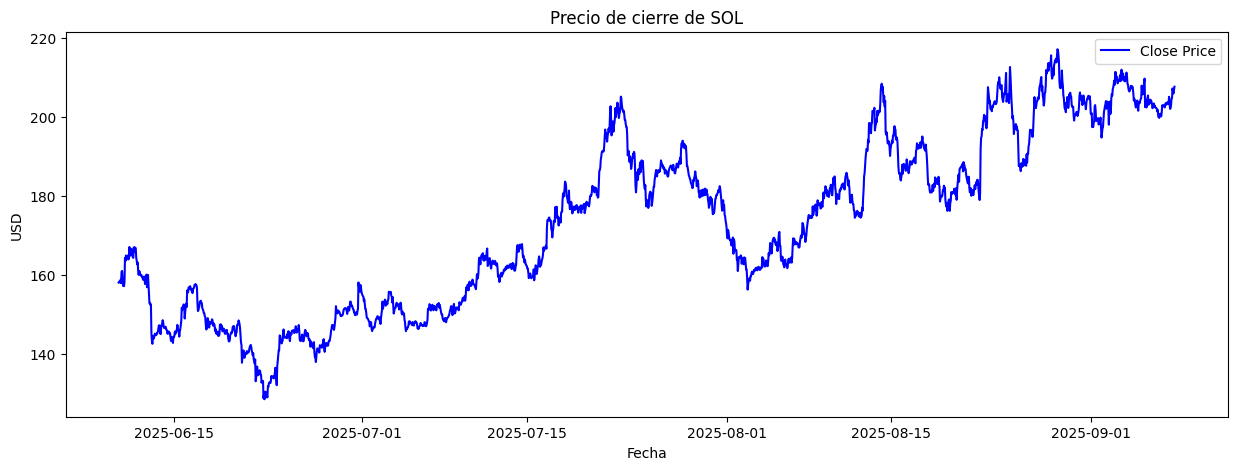

📊 Visualizando volumen de trading...


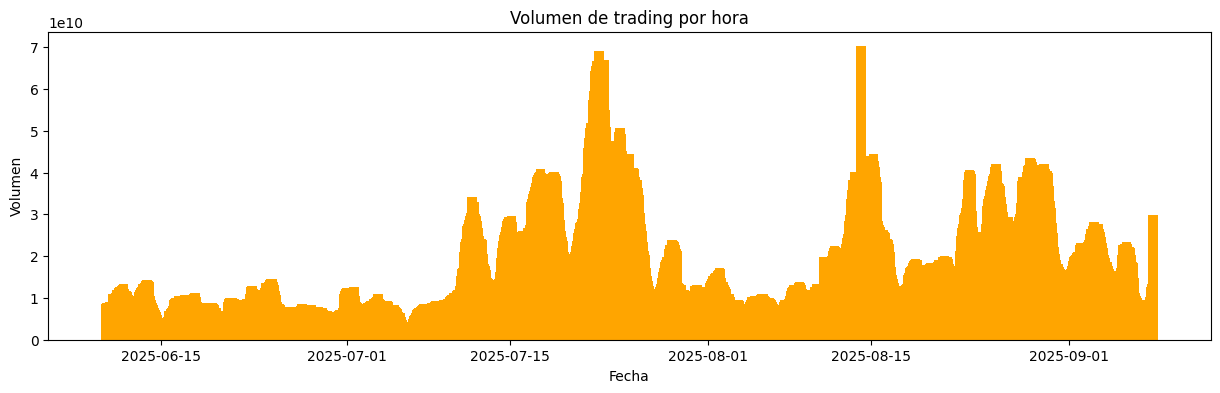

📊 Visualizando retornos horarios...


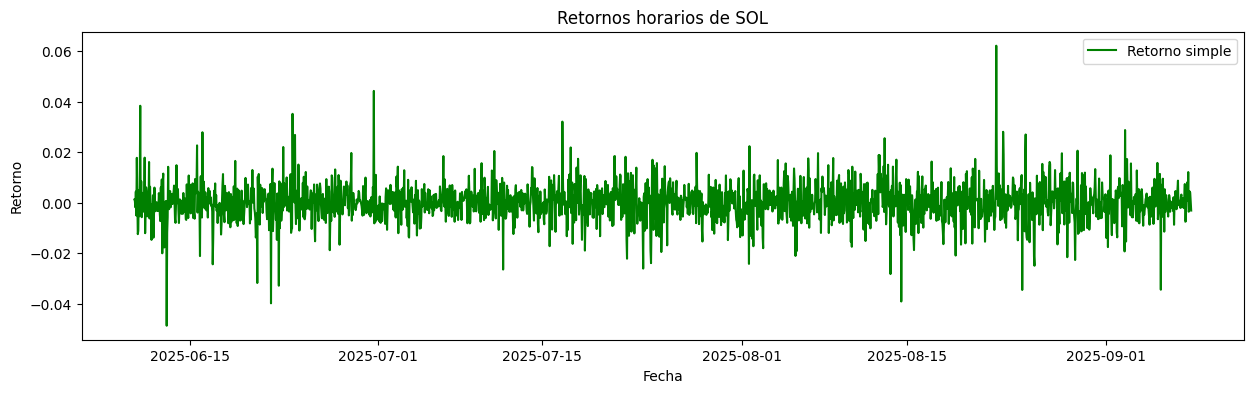

📊 Distribución de retornos horarios...


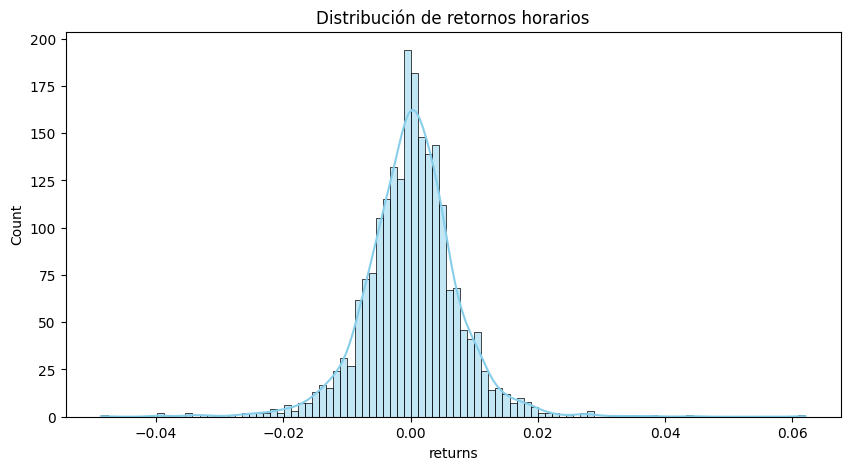

📊 Visualizando medias móviles...


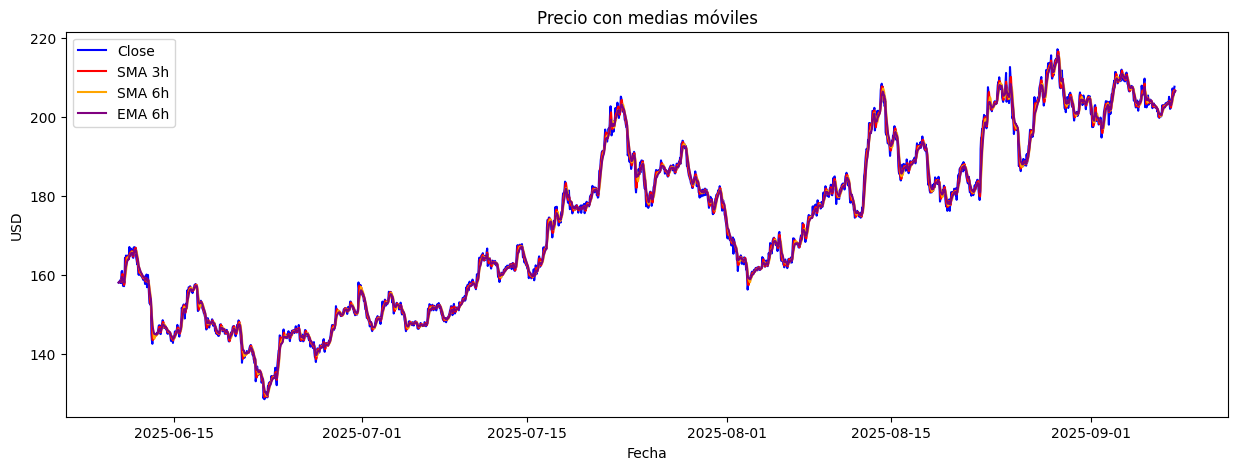

📊 Visualizando volumen relativo...


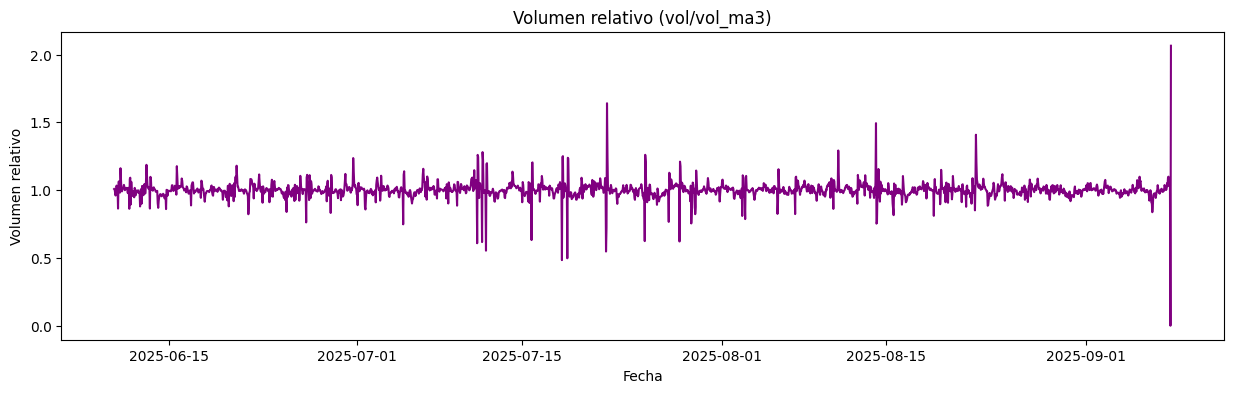

📊 Resumen estadístico del dataset:
                           timestamp         open         high          low  \
count                           2160  2159.000000  2159.000000  2159.000000   
mean   2025-07-25 05:30:00.000000256   173.053064   173.053065   173.052665   
min              2025-06-10 06:00:00   128.602469   128.602469   128.602469   
25%              2025-07-02 17:45:00   152.195731   152.195731   152.195731   
50%              2025-07-25 05:30:00   174.842212   174.842212   174.842212   
75%              2025-08-16 17:15:00   190.257543   190.257543   190.257543   
max              2025-09-08 05:00:00   217.184806   217.184806   217.184806   
std                              NaN    21.810399    21.810400    21.809769   

             close        volume      returns  log_returns       change  \
count  2159.000000  2.160000e+03  2159.000000  2157.000000  2159.000000   
mean    173.052666  1.829435e+10     0.000153     0.000126    -0.000398   
min     128.602469  0.000000

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🚀 Iniciando EDA automático para SOL...")

# 1️⃣ Cargar dataset preparado
df = pd.read_csv("solana_5000h_preparado.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2️⃣ Gráfico del precio de cierre
print("📊 Visualizando precio de cierre...")
plt.figure(figsize=(15,5))
plt.plot(df['timestamp'], df['close'], label='Close Price', color='blue')
plt.title('Precio de cierre de SOL')
plt.xlabel('Fecha')
plt.ylabel('USD')
plt.legend()
plt.show()

# 3️⃣ Gráfico de volumen
print("📊 Visualizando volumen de trading...")
plt.figure(figsize=(15,4))
plt.bar(df['timestamp'], df['volume'], color='orange')
plt.title('Volumen de trading por hora')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.show()

# 4️⃣ Retornos y log-retornos
print("📊 Visualizando retornos horarios...")
plt.figure(figsize=(15,4))
plt.plot(df['timestamp'], df['returns'], label='Retorno simple', color='green')
plt.title('Retornos horarios de SOL')
plt.xlabel('Fecha')
plt.ylabel('Retorno')
plt.legend()
plt.show()

# 5️⃣ Histograma de retornos
print("📊 Distribución de retornos horarios...")
plt.figure(figsize=(10,5))
sns.histplot(df['returns'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Distribución de retornos horarios')
plt.show()

# 6️⃣ Medias móviles sobre el precio
print("📊 Visualizando medias móviles...")
plt.figure(figsize=(15,5))
plt.plot(df['timestamp'], df['close'], label='Close', color='blue')
plt.plot(df['timestamp'], df['SMA_3'], label='SMA 3h', color='red')
plt.plot(df['timestamp'], df['SMA_6'], label='SMA 6h', color='orange')
plt.plot(df['timestamp'], df['EMA_6'], label='EMA 6h', color='purple')
plt.title('Precio con medias móviles')
plt.xlabel('Fecha')
plt.ylabel('USD')
plt.legend()
plt.show()

# 7️⃣ Volumen relativo
print("📊 Visualizando volumen relativo...")
plt.figure(figsize=(15,4))
plt.plot(df['timestamp'], df['vol_ratio'], color='purple')
plt.title('Volumen relativo (vol/vol_ma3)')
plt.xlabel('Fecha')
plt.ylabel('Volumen relativo')
plt.show()

# 8️⃣ Resumen estadístico rápido
print("📊 Resumen estadístico del dataset:")
print(df.describe())

print("✅ EDA completado. Observa los gráficos para identificar patrones y volatilidad.")


🚀 Visualizando picos de retorno y volumen...


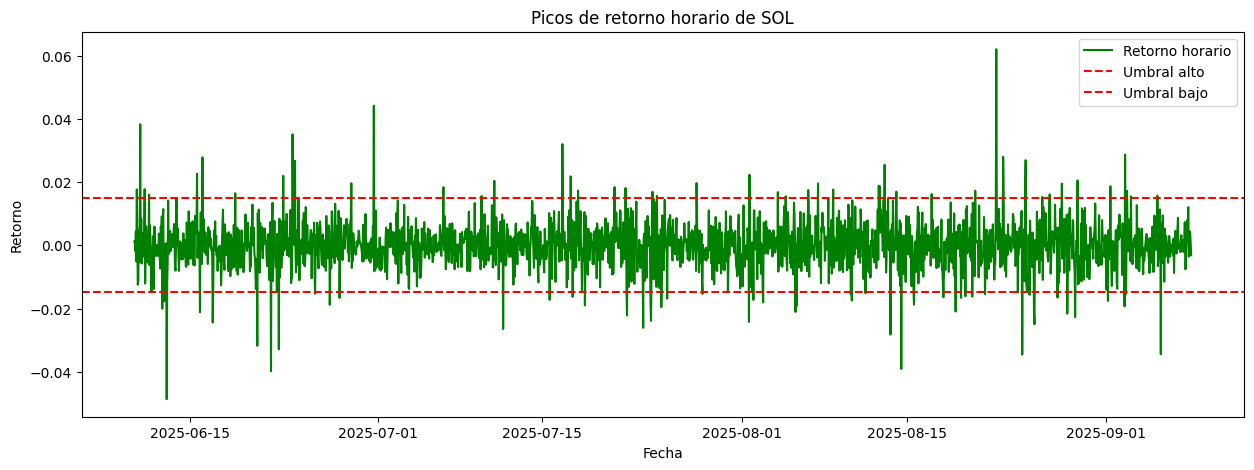

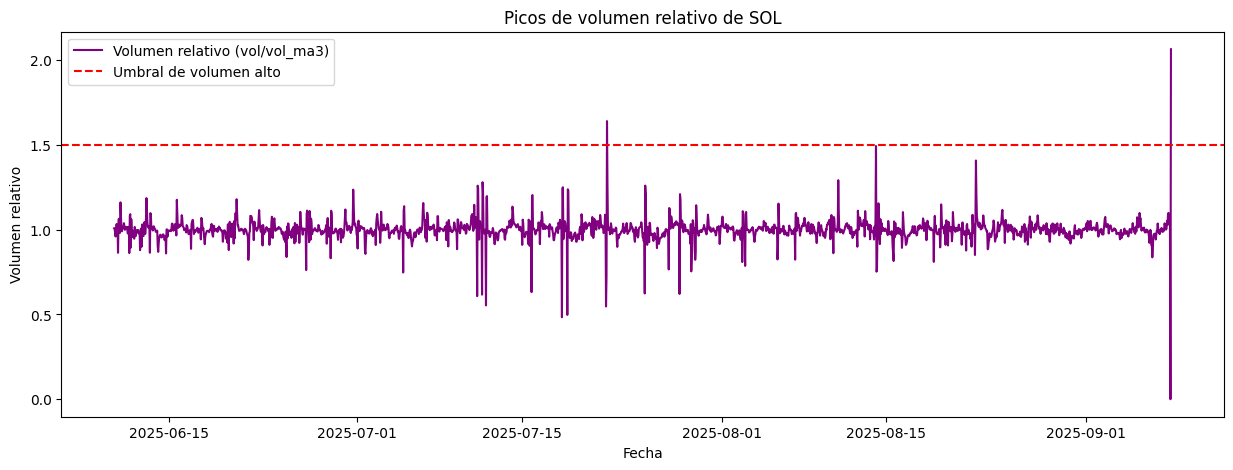

✅ Gráficos generados. Observa los picos para identificar posibles pumps o momentos de alta actividad.


In [6]:
import matplotlib.pyplot as plt

print("🚀 Visualizando picos de retorno y volumen...")

# 1️⃣ Picos de retorno
plt.figure(figsize=(15,5))
plt.plot(df['timestamp'], df['returns'], label='Retorno horario', color='green')
plt.axhline(y=df['returns'].mean() + 2*df['returns'].std(), color='red', linestyle='--', label='Umbral alto')
plt.axhline(y=df['returns'].mean() - 2*df['returns'].std(), color='red', linestyle='--', label='Umbral bajo')
plt.title('Picos de retorno horario de SOL')
plt.xlabel('Fecha')
plt.ylabel('Retorno')
plt.legend()
plt.show()

# 2️⃣ Picos de volumen relativo
plt.figure(figsize=(15,5))
plt.plot(df['timestamp'], df['vol_ratio'], label='Volumen relativo (vol/vol_ma3)', color='purple')
plt.axhline(y=1.5, color='red', linestyle='--', label='Umbral de volumen alto')
plt.title('Picos de volumen relativo de SOL')
plt.xlabel('Fecha')
plt.ylabel('Volumen relativo')
plt.legend()
plt.show()

print("✅ Gráficos generados. Observa los picos para identificar posibles pumps o momentos de alta actividad.")


🚀 Generando etiquetas de posibles pumps...
✅ Total de horas con posible pump detectadas: 0


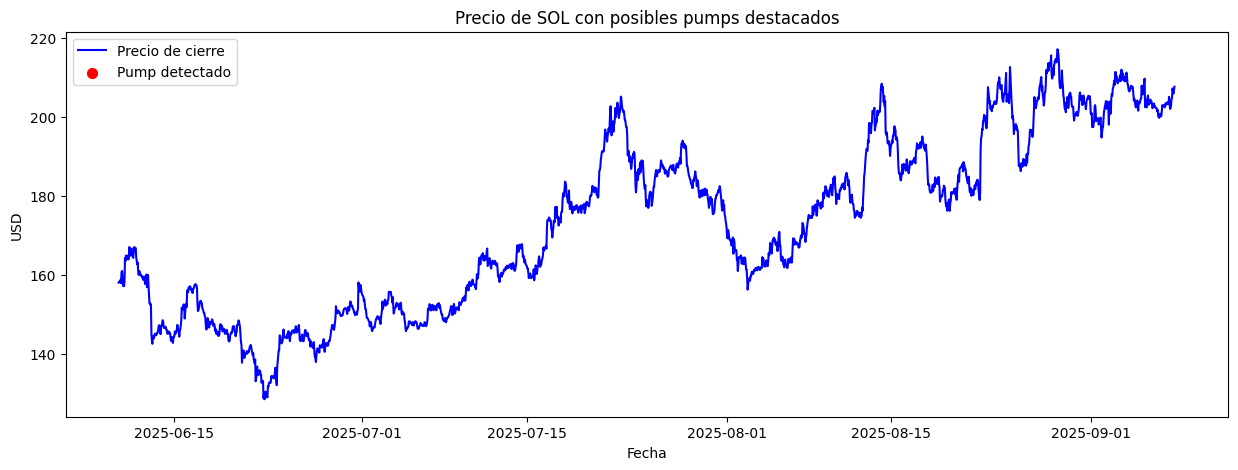

✅ Señales generadas y visualizadas. Las velas rojas indican horas con pump potencial.


In [7]:
print("🚀 Generando etiquetas de posibles pumps...")

# 1️⃣ Definir umbrales
# Retornos extremos: 2 desviaciones estándar
return_upper = df['returns'].mean() + 2*df['returns'].std()
return_lower = df['returns'].mean() - 2*df['returns'].std()

# Volumen alto: volumen relativo > 1.5
vol_threshold = 1.5

# 2️⃣ Crear columna de señal
df['pump_signal'] = ((df['returns'] > return_upper) & (df['vol_ratio'] > vol_threshold)).astype(int)

# 3️⃣ Resumen de señales
num_pumps = df['pump_signal'].sum()
print(f"✅ Total de horas con posible pump detectadas: {num_pumps}")

# 4️⃣ Visualizar
plt.figure(figsize=(15,5))
plt.plot(df['timestamp'], df['close'], label='Precio de cierre', color='blue')
plt.scatter(df[df['pump_signal']==1]['timestamp'], 
            df[df['pump_signal']==1]['close'], 
            color='red', label='Pump detectado', s=50)
plt.title('Precio de SOL con posibles pumps destacados')
plt.xlabel('Fecha')
plt.ylabel('USD')
plt.legend()
plt.show()

print("✅ Señales generadas y visualizadas. Las velas rojas indican horas con pump potencial.")


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

print("🚀 Preparando datos para predicción de pumps...")

# 1️⃣ Features
# Vamos a usar:
# - returns
# - vol_ratio
# - SMA_3, SMA_6
# - EMA_6
features = ['returns', 'vol_ratio', 'SMA_3', 'SMA_6', 'EMA_6']

X = df[features].iloc[:-1]  # todas menos la última hora
y = df['pump_signal'].shift(-1).fillna(0).iloc[:-1]  # señal de la próxima hora

# 2️⃣ Train-test split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3️⃣ Entrenar modelo
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 4️⃣ Evaluar en test
y_pred = model.predict(X_test)
print("\n📊 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# 5️⃣ Predecir las próximas 30 horas
last_rows = df[features].tail(30)
future_preds = model.predict(last_rows)

# Resultado
for i, val in enumerate(future_preds, 1):
    print(f"Hora +{i}: {'Pump potencial 🚀' if val==1 else 'No pump'}")


🚀 Preparando datos para predicción de pumps...

📊 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       432

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432

Hora +1: No pump
Hora +2: No pump
Hora +3: No pump
Hora +4: No pump
Hora +5: No pump
Hora +6: No pump
Hora +7: No pump
Hora +8: No pump
Hora +9: No pump
Hora +10: No pump
Hora +11: No pump
Hora +12: No pump
Hora +13: No pump
Hora +14: No pump
Hora +15: No pump
Hora +16: No pump
Hora +17: No pump
Hora +18: No pump
Hora +19: No pump
Hora +20: No pump
Hora +21: No pump
Hora +22: No pump
Hora +23: No pump
Hora +24: No pump
Hora +25: No pump
Hora +26: No pump
Hora +27: No pump
Hora +28: No pump
Hora +29: No pump
Hora +30: No pump


In [9]:
from sklearn.ensemble import RandomForestRegressor

print("🚀 Prediciendo precio de SOL para las próximas 30 horas...")

# 1️⃣ Features: podemos usar retornos, medias y volumen
features = ['returns', 'vol_ratio', 'SMA_3', 'SMA_6', 'EMA_6']
X = df[features].iloc[:-1]
y = df['close'].shift(-1).iloc[:-1]  # precio de la próxima hora

# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3️⃣ Entrenar modelo de regresión
model_reg = RandomForestRegressor(n_estimators=200, random_state=42)
model_reg.fit(X_train, y_train)

# 4️⃣ Predecir las próximas 30 horas
last_rows = df[features].tail(30)
future_prices = model_reg.predict(last_rows)

# 5️⃣ Mostrar resultados
for i, price in enumerate(future_prices, 1):
    print(f"Hora +{i}: Predicción de precio ≈ ${price:.2f}")


🚀 Prediciendo precio de SOL para las próximas 30 horas...
Hora +1: Predicción de precio ≈ $200.22
Hora +2: Predicción de precio ≈ $201.92
Hora +3: Predicción de precio ≈ $201.79
Hora +4: Predicción de precio ≈ $201.98
Hora +5: Predicción de precio ≈ $201.21
Hora +6: Predicción de precio ≈ $201.46
Hora +7: Predicción de precio ≈ $201.65
Hora +8: Predicción de precio ≈ $201.58
Hora +9: Predicción de precio ≈ $202.01
Hora +10: Predicción de precio ≈ $202.43
Hora +11: Predicción de precio ≈ $201.98
Hora +12: Predicción de precio ≈ $202.12
Hora +13: Predicción de precio ≈ $202.40
Hora +14: Predicción de precio ≈ $202.08
Hora +15: Predicción de precio ≈ $202.46
Hora +16: Predicción de precio ≈ $202.42
Hora +17: Predicción de precio ≈ $201.63
Hora +18: Predicción de precio ≈ $202.27
Hora +19: Predicción de precio ≈ $202.65
Hora +20: Predicción de precio ≈ $201.60
Hora +21: Predicción de precio ≈ $202.44
Hora +22: Predicción de precio ≈ $201.76
Hora +23: Predicción de precio ≈ $201.18
Hora +24